<a href="https://colab.research.google.com/github/Andrea-Cristini/sailgp/blob/main/SailGP_tack_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6291 entries, 0 to 6290
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              6291 non-null   int64  
 1   BOAT                    6291 non-null   object 
 2   type                    6291 non-null   object 
 3   WING_CONFIG_unk         6291 non-null   float64
 4   DATETIME                6291 non-null   object 
 5   entry_bsp               6291 non-null   float64
 6   exit_bsp                6291 non-null   float64
 7   min_bsp                 6291 non-null   float64
 8   bsp_loss                6291 non-null   float64
 9   entry_twa               6291 non-null   float64
 10  exit_twa                6291 non-null   float64
 11  entry_rh                6288 non-null   float64
 12  exit_rh                 6291 non-null   float64
 13  entry_rh_stability      6276 non-null   float64
 14  max_yaw_rate            6291 non-null   

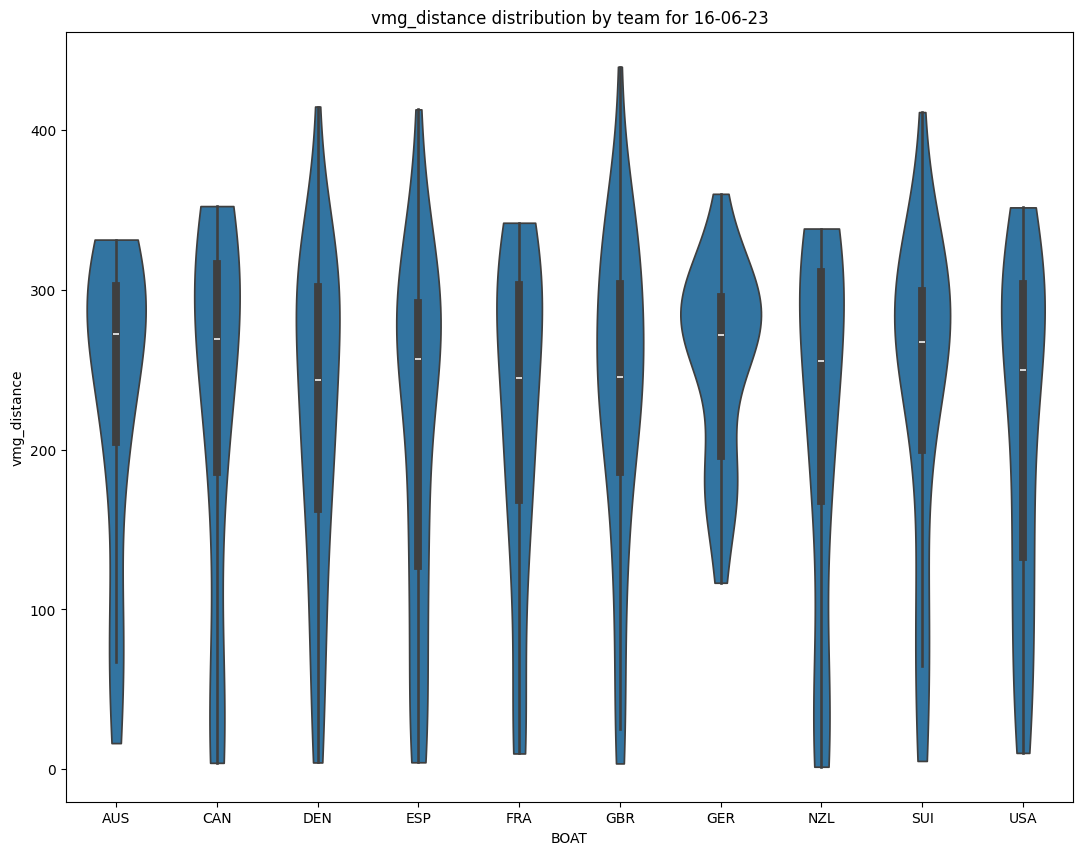

Index(['Unnamed: 0', 'BOAT', 'type', 'WING_CONFIG_unk', 'DATETIME',
       'entry_bsp', 'exit_bsp', 'min_bsp', 'bsp_loss', 'entry_twa', 'exit_twa',
       'entry_rh', 'exit_rh', 'entry_rh_stability', 'max_yaw_rate',
       'two_DB_time', 'tws', 'pop_time', 'turn_min_rh', 't_invert',
       'entry_heel', 'entry_pitch', 'exit_heel', 'exit_pitch', 'turning_time',
       'bsp_at_drop', 'heel_at_drop', 'entry_jib_lead', 'exit_jib_lead',
       'entry_jib_sheet', 'exit_jib_sheet', 'max_rudder_angle', 'vmg_distance',
       'theoretical_target_vmg', 'DATE'],
      dtype='object')


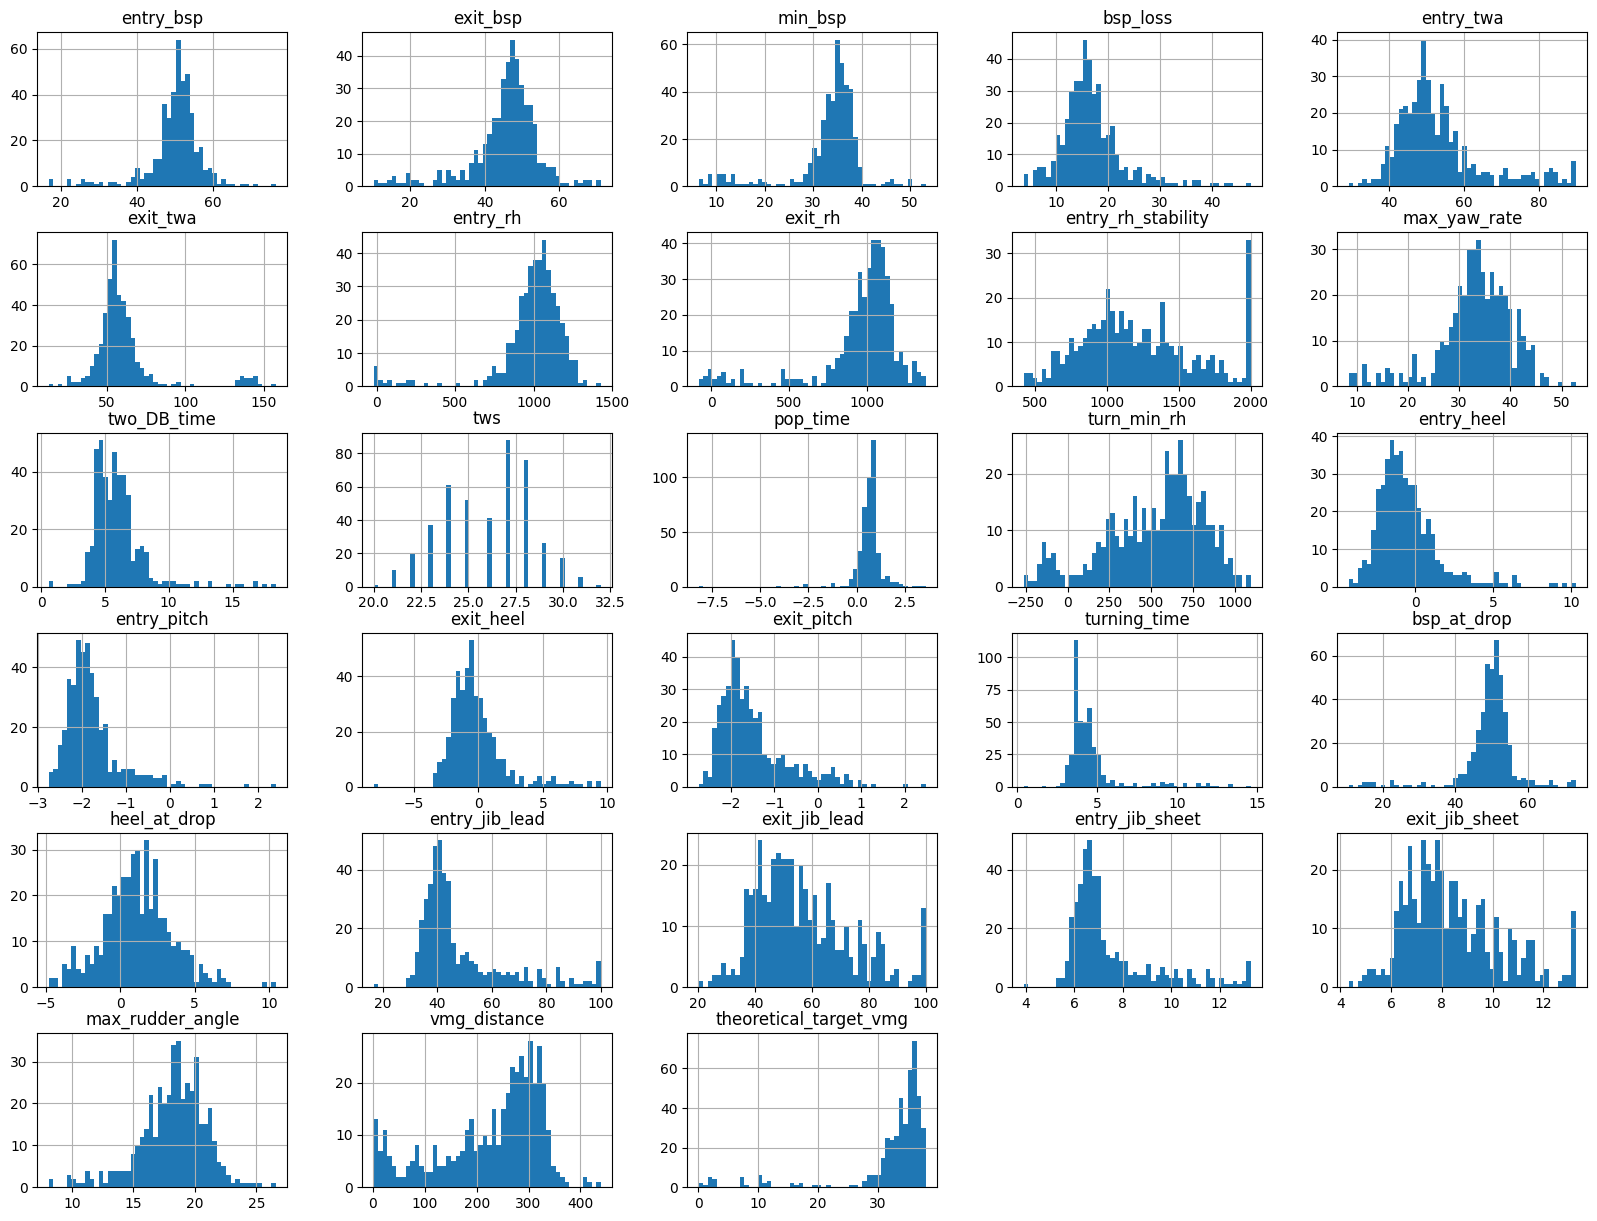

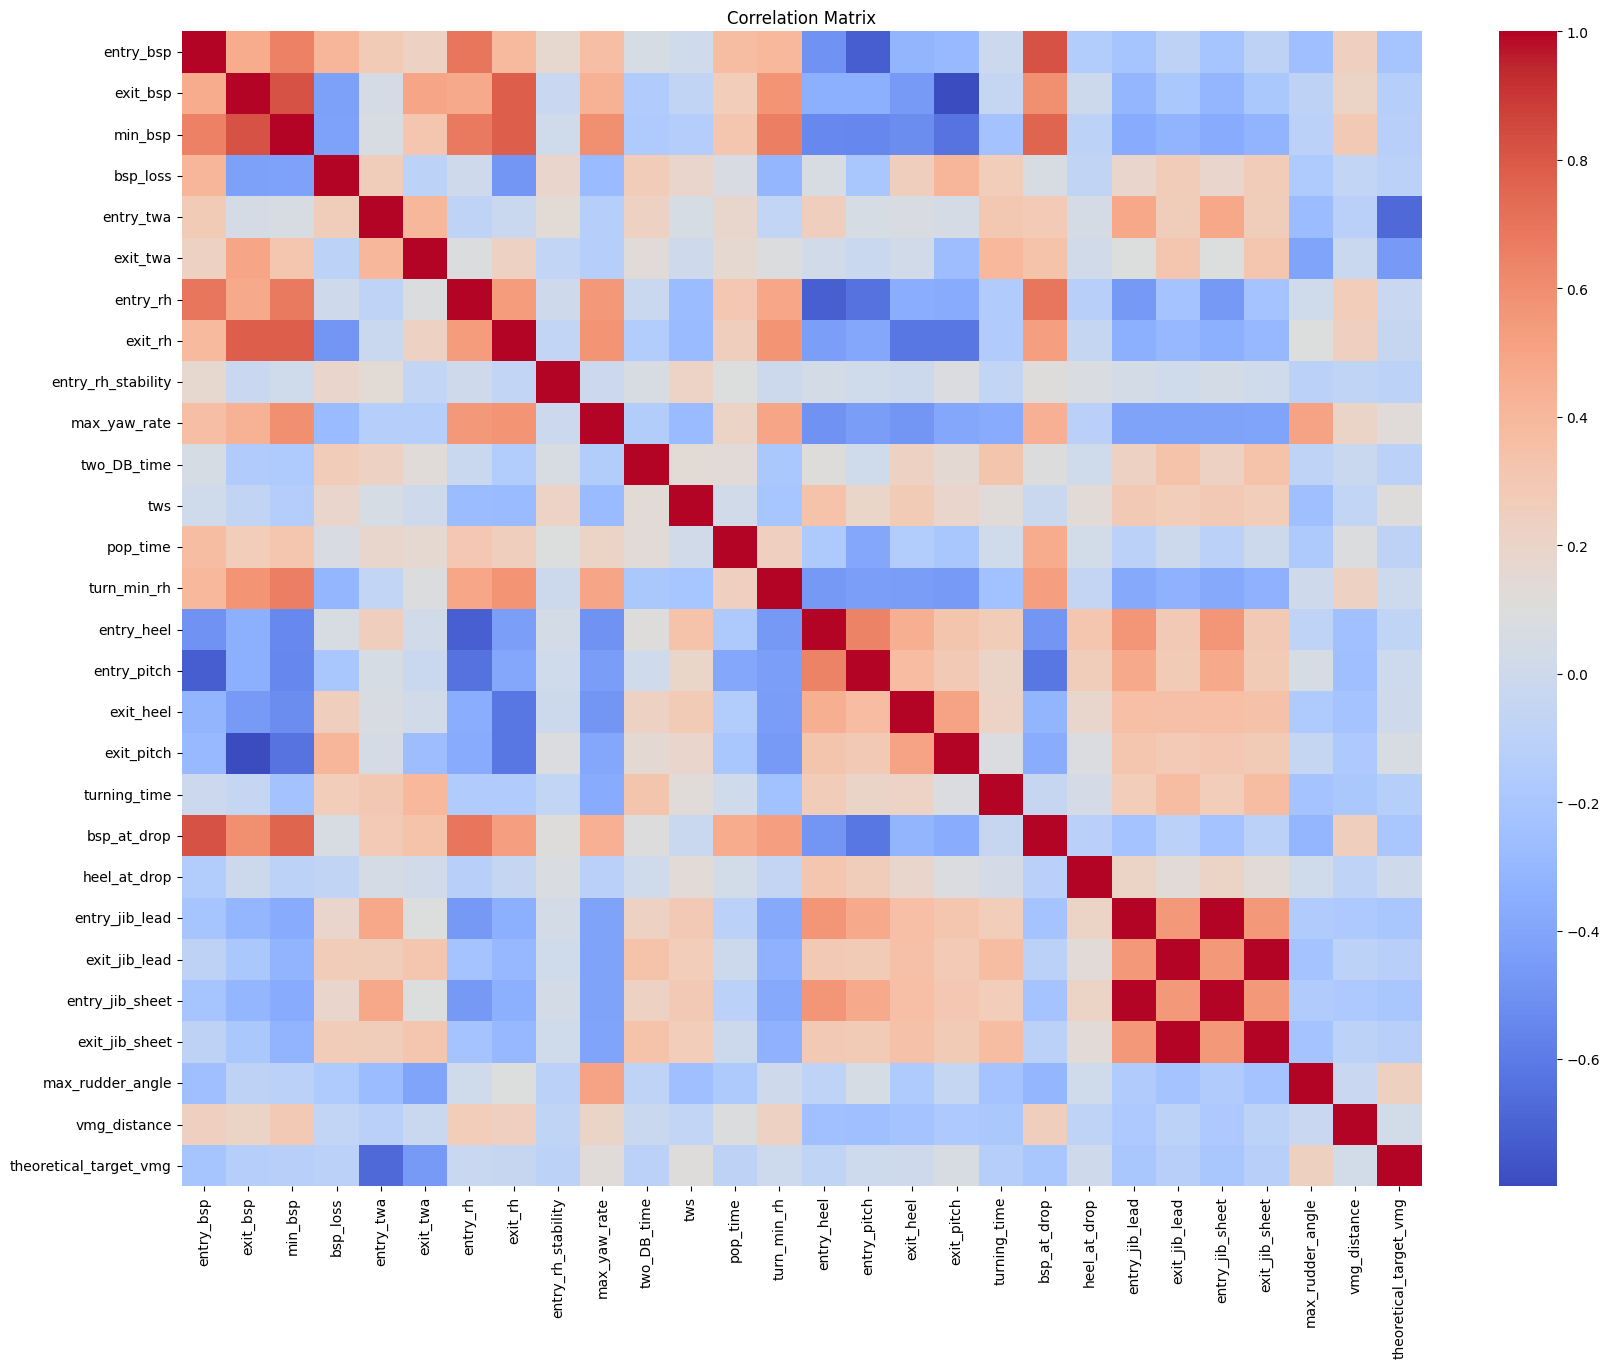

Index(['BOAT', 'WING_CONFIG_unk', 'DATETIME', 'entry_bsp', 'exit_bsp',
       'bsp_loss', 'entry_twa', 'exit_twa', 'entry_rh', 'exit_rh',
       'entry_rh_stability', 'max_yaw_rate', 'two_DB_time', 'tws', 'pop_time',
       'turn_min_rh', 'entry_heel', 'entry_pitch', 'exit_heel', 'exit_pitch',
       'turning_time', 'heel_at_drop', 'entry_jib_lead', 'exit_jib_lead',
       'max_rudder_angle', 'vmg_distance', 'theoretical_target_vmg', 'DATE'],
      dtype='object')
BOAT                       0
WING_CONFIG_unk            0
DATETIME                   0
entry_bsp                  0
exit_bsp                   0
bsp_loss                   0
entry_twa                  0
exit_twa                   0
entry_rh                   3
exit_rh                    0
entry_rh_stability        15
max_yaw_rate               0
two_DB_time               72
tws                        0
pop_time                  16
turn_min_rh               15
entry_heel                 0
entry_pitch                0
exit_heel

<Figure size 2000x1500 with 0 Axes>

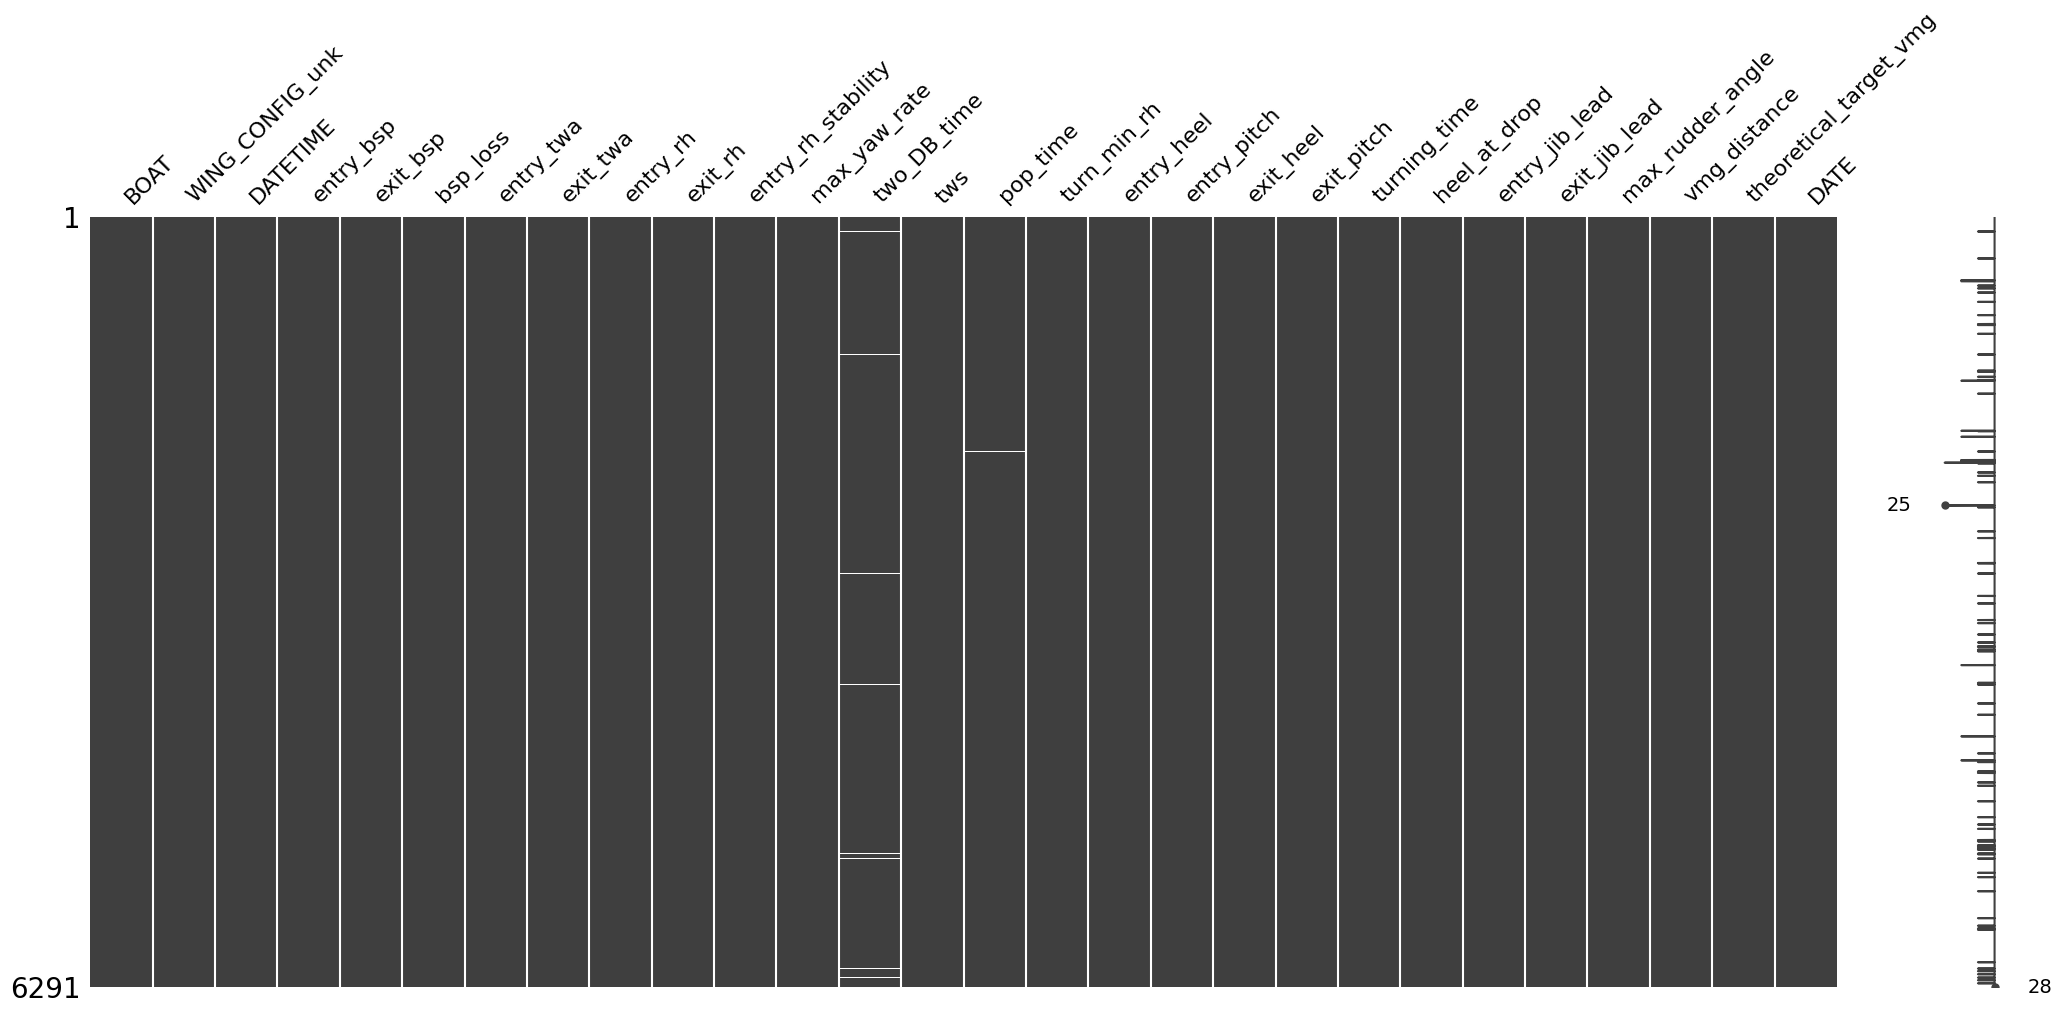

entry_rh              1022.05
entry_rh_stability     961.25
two_DB_time              5.40
pop_time                 1.00
turn_min_rh            442.95
dtype: float64
entry_rh              1022.05
entry_rh_stability     961.25
two_DB_time              5.40
pop_time                 1.00
turn_min_rh            442.95
dtype: float64
BOAT                      0
WING_CONFIG_unk           0
DATETIME                  0
entry_bsp                 0
exit_bsp                  0
bsp_loss                  0
entry_twa                 0
exit_twa                  0
entry_rh                  0
exit_rh                   0
entry_rh_stability        0
max_yaw_rate              0
two_DB_time               0
tws                       0
pop_time                  0
turn_min_rh               0
entry_heel                0
entry_pitch               0
exit_heel                 0
exit_pitch                0
turning_time              0
heel_at_drop              0
entry_jib_lead            0
exit_jib_lead             

SystemExit: 

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [93]:
""" SailGP tack analysis project.
    -----------------------------
    Notebook which imports the dataset, performs
    some EDA, generates some features, builds some
    candidate models, evaluates model accuracy etc
    and interprets the model results """

# 1. Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
#import shap
import sys

mrow = 100
pd.options.display.min_rows = 0
pd.options.display.max_rows = mrow
pd.options.display.max_columns = mrow

# 2. Load the Dataset
df = pd.read_csv('tack_analysis.csv')

# 3. Exploratory Data Analysis (EDA)

# 3.1 Basic Information
print(df.info())
print(df.describe())

df['DATE'] = pd.to_datetime(df['DATETIME'], format='mixed').dt.date
for cat in ('BOAT','type','DATE'):
  print(df[cat].value_counts())

print(df['DATE'])
sample_date = pd.to_datetime('2023-06-16').date()
df_samp = df[df['DATE']==sample_date]
print(df_samp['BOAT'].value_counts())
print(df_samp['vmg_distance'].nsmallest(10))

# 3.2 Missing Values
missing_values = df.isnull().sum()
print(missing_values)
#TODO: remove rows with minimal number of missing values,
#      maybe impute jib_sheet

#df_red = df[['BOAT','vmg_distance']]
# 3.3 Target Variable Distribution
fig = plt.figure(figsize=(13.,10.))
sns.violinplot(x='BOAT', y='vmg_distance',data=df_samp, cut=0)
plt.title('vmg_distance distribution by team for 16-06-23')
plt.show()

# 3.4 Feature Distributions
print(df_samp.columns)
df_samp_num = df_samp.drop(columns=(['Unnamed: 0','BOAT','type',
    'WING_CONFIG_unk','DATETIME','DATE','t_invert']))
df_samp_num.hist(bins=50, figsize=(20, 15))
plt.show()

# 3.5 Correlation Matrix
fig = plt.figure(figsize=(20.,15.))
corr_matrix = df_samp_num.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
#NOTE: exit boatspeed and min boatspeed are highly correlated,
#      also the boatspeed at drop is highly correlated with the
#      entry boatspeed. At least one of these four variables could
#      be removed, suggest removal of min boatspeed as
#      loss = entry - min, and loss is a relative measure. Also
#      suggest removal of bsp_at_drop in place of entry_bsp.

#NOTE: entry_jib_lead/entry_jib_sheet and exit_jib_lead/exit_jib_sheet
#      are highly correlated. As the data quality of the jib_sheet
#      variables are poor, suggest removal of these variables in place
#      of their lead analogues

df_clean = df.drop(columns=(['Unnamed: 0','type','t_invert',
            'bsp_at_drop','min_bsp','entry_jib_sheet','exit_jib_sheet']))
print(df_clean.columns)

missing_values = df_clean.isnull()
#df_imp = df_clean[missing_values==True]
#print(df_imp.columns)
#print(df_clean[missing_values.any(axis=1)])
print(missing_values.sum())
cols_miss = df_clean.columns[missing_values.sum() > 0]
print(cols_miss)

fig = plt.figure(figsize=(20, 15))
#sns.heatmap(missing_values.corr(), annot=True, cmap='coolwarm')
msno.matrix(df_clean)
plt.show()

#TODO: impute missing values with their median values as all
#      distributions with missing values are non-normal

meds = df_clean[cols_miss].median()
print(meds)

df_clean[cols_miss] = df_clean[cols_miss].fillna(meds)

meds = df_clean[cols_miss].median()
print(meds)

missing_values = df_clean.isnull()
print(missing_values.sum())

sys.exit()

# 4. Feature Engineering
# feature ideas:
# 1) deceleration = (bsp_loss)/(15/3600)
#   if turning_time = time between entry and exit then use
#   half of this instead for the time
# 2) time between tacks = datetime[n+1] - (datetime[n] + turning_time)

# 4.1 Handling Missing Values
# Fill missing values or drop missing data
df['column'] = df['column'].fillna(df['column'].mean())

# 4.2 Encoding Categorical Variables
categorical_features = df.select_dtypes(include=['object']).columns
for col in categorical_features:
    df[col] = df[col].astype('category').cat.codes

# 4.3 Feature Scaling
scaler = StandardScaler()
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# 5. Model Building

# 5.1 Split the Data
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5.2 Define the Model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 5.3 Train the Model
model.fit(X_train, y_train)

# 6. Model Evaluation

# 6.1 Predictions
y_pred = model.predict(X_test)

# 6.2 Classification Report
print(classification_report(y_test, y_pred))

# 6.3 Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 7. Model Interpretation

# 7.1 Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

# 7.2 SHAP Values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 7.3 SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

# 7.4 SHAP Dependence Plot
shap.dependence_plot('feature_name', shap_values[1], X_test)

# 8. Conclusion and Next Steps
# Summarize findings, potential improvements, and next steps for further analysis
